# Imports and Defaults

In [1]:
# import subprocess
# subprocess.run(["pip", "install", "-q", "-e", "../bayes-kit"])

In [48]:
import json
import os
import itertools
from collections import defaultdict
import asyncio
import nest_asyncio

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
from tqdm import trange
from tqdm.asyncio import tqdm

from src.utils import get_model
from bayes_kit.ess import ess
from bayes_kit.rhat import rhat


In [11]:
# SET THESE VALUES
MODEL_NUM = 2

In [21]:
# DEFAULTS
PDB_DIR = "models"
RES_DIR = "res"
FIGURE_DIR = "figures"
MAX_NUMBER_PROPOSALS = 4
ROOT_DIR = os.path.join(RES_DIR, f"PDB_{MODEL_NUM:02d}")
SAMPLER_DIRS = next(os.walk(ROOT_DIR))[1]

# plt.ioff()
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")
mplstyle.use('fast')
nest_asyncio.apply()

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
# %config InlineBackend.figure_format = "svg" # "retina"

# DataFrame and Plots Generation

In [5]:
def init():
    num_samplers = len(SAMPLER_DIRS)

    fname = os.path.join(ROOT_DIR, SAMPLER_DIRS[0])
    num_chains = len(next(os.walk(fname))[1])

    fname = os.path.join(ROOT_DIR, SAMPLER_DIRS[0], "chain_01", "draws.npy")
    draws = np.load(fname)
    num_model_params = draws.shape[1]
    
    return num_samplers, num_chains, num_model_params

def init_reference():
    model = get_model(MODEL_NUM, PDB_DIR)
    fname = os.path.join(
        PDB_DIR, f"PDB_{MODEL_NUM:02d}", f"PDB_{MODEL_NUM:02d}.samples.npy"
    )
    num_ref_chains = np.load(fname).shape[0]
    return num_ref_chains

In [6]:
def get_draws(sampler_dir, chain_num):
    fname = os.path.join(ROOT_DIR, sampler_dir, f"chain_{chain_num + 1:02d}", "draws.npy")
    draws = np.load(fname).astype(np.float32)
    return draws

def get_burned_draws(sampler_dir, chain_num):
    fname = os.path.join(ROOT_DIR, sampler_dir, f"chain_{chain_num + 1:02d}", "burned_draws.npy")
    burned_draws = np.load(fname).astype(np.float32)
    return burned_draws


def parse(sampler_params):
    # remove sampler params that are not relevant to the experiment
    include_keys = ["sampler_type"]
    parsed = []
    
    for key in list(sampler_params.keys()):
        if key in include_keys:
            parsed.append(str(sampler_params[key]))
            
    return "\n".join(parsed) # split by newline


def get_sampler_params(sampler_dir, chain_num):
    fname = os.path.join(ROOT_DIR, sampler_dir, f"chain_{chain_num + 1:02d}", "sampler_params.json")
    with open(fname) as f:
        sampler_params = json.load(f)
    return sampler_params


def extract_my_data(sampler_num, chain_num):
    sampler_dir = SAMPLER_DIRS[sampler_num]
    
    draws = get_draws(sampler_dir, chain_num)
    burned_draws = get_burned_draws(sampler_dir, chain_num)
    sampler_params = get_sampler_params(sampler_dir, chain_num)
    return draws, burned_draws, sampler_params


def get_ref_draws(chain_num):
    model = get_model(MODEL_NUM, PDB_DIR)
    fname = os.path.join(
        PDB_DIR, f"PDB_{MODEL_NUM:02d}", f"PDB_{MODEL_NUM:02d}.samples.npy"
    )
    
    constrained = np.load(fname)[chain_num, :, :].copy(
        order="C"
    )  # [chain_num, n_samples, params_dim]
    reference_draws = model.unconstrain(constrained).astype(np.float32)
    return reference_draws

In [49]:
def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)

    return wrapped

@background
def helper(sampler, num_model_params, num_chains):
    stats_df_list = []
    rhat_dict = defaultdict(list)
    for chain in range(num_chains):
        all_draws, all_burned_draws, sampler_params = extract_my_data(sampler, chain)
        for model_param in range(num_model_params):

            # pre-processing
            draws, burned_draws = all_draws[:, model_param], all_burned_draws[:, model_param]
            rhat_dict[model_param].append(draws)

            # add statsistics to dataframe
            stats_row = {
                "model_param": model_param,
                "sampler": sampler,
                "chain": chain,
                "mean": np.mean(draws),
                "std": np.std(draws),
                "ess/grad_eval": ess(draws) / sampler_params["grad_evals"],
                "ess^2/grad_eval": ess(draws**2) / sampler_params["grad_evals"],
            }
            for k, v in sampler_params.items():
                stats_row[k] = v
            stats_row["sampler_params"] = "\n".join(f"{k}: {v}" for k, v in sampler_params.items())
            stats_df_list.append(stats_row)

    # compute rhat statistic separately
    for model_param in range(num_model_params):
        rhat_val = rhat(rhat_dict[model_param])
        for chain in range(num_chains):
            idx = (chain * num_model_params) + model_param
            stats_row = stats_df_list[idx]
            stats_row["rhat"] = rhat_val
            
    return stats_df_list

def create_df(num_samplers, num_chains, num_model_params, num_ref_chains):
    
    ### my draws ###
    # iterate over samplers, chains, and model params with asyncio
    loop = asyncio.get_event_loop()
    # looper = asyncio.gather(*[helper(sampler, num_model_params, num_chains) for sampler in range(num_samplers)])
    looper = tqdm.gather(*[helper(sampler, num_model_params, num_chains) for sampler in range(num_samplers)])
    res = loop.run_until_complete(looper)            
    stats_df_list = list(itertools.chain.from_iterable(res))
        
    ### reference draws ###
    # iterate over chains and model params
    ref_dict = defaultdict(list)
    for chain in range(num_ref_chains):
        all_ref_draws = get_ref_draws(chain)
        for model_param in range(num_model_params):
            
            # pre-processing
            ref_draws = all_ref_draws[:, model_param]
            ref_dict[model_param].append(ref_draws)
            
            # add statistics to dataframe
            stats_row = {
                "model_param": model_param,
                "sampler": -1,
                "chain": chain,
                "mean": np.mean(ref_draws),
                "std": np.std(ref_draws),
            }
            stats_df_list.append(stats_row)
            
    # compute rhat statistic separately
    for model_param in range(num_model_params):
        rhat_val = rhat(ref_dict[model_param])
        for chain in range(num_chains):
            idx = idx = (num_samplers * num_chains * num_model_params) + (chain * num_model_params) + model_param
            stats_row = stats_df_list[idx]
            stats_row["rhat"] = rhat_val
            
    # stats post-processing
    stats_df = pd.DataFrame(stats_df_list).sort_values(by=["model_param", "sampler", "chain"])
    return stats_df

In [50]:
def plot_stats(df, value_vars=None, id_vars=None, model_params=None, save=False):
    if value_vars is None:
        value_vars = (
            ["mean", "std", "rhat", "ess/grad_eval", "ess^2/grad_eval", "accept_total"] + 
            [f"accept_{i}" for i in range(MAX_NUMBER_PROPOSALS)]
        )
    if model_params is None:
        model_params = df["model_param"].unique()
    if id_vars is None:
        id_vars = ["sampler", "chain"]
    id_vars += ["sampler_type"]
    
    num_samplers = df["sampler"].nunique()    
    fig_list = []
    for model_param in model_params:
        model_param_hmc = df[df["model_param"] == model_param]
        melted = pd.melt(model_param_df, id_vars=id_vars, value_vars=value_vars)
        
        stats_fig = sns.catplot(data=melted, x=id_vars[0], y="value",
                                col="variable", col_wrap=2, hue="sampler_type",
                                sharex=False, sharey=False,
                                legend=True, aspect=4,)
        stats_fig.fig.subplots_adjust(top=0.9)
        stats_fig.fig.suptitle(f"Model Param {model_param}", fontsize=20)
        [ax.tick_params(axis='x', labelsize=num_samplers // 20, labelrotation=0) for ax in stats_fig.axes]
        
        if "mean" in value_vars:
            ax_mean = [stats_fig.axes[i] for i, v in enumerate(value_vars) if v == "mean"][0]
            xmin, xmax = ax_mean.get_xlim()
            avg_ref_mean = np.mean(REF_MEAN[(4 * model_param) : (4 * model_param) + 4])
            ax_mean.hlines(y=avg_ref_mean, xmin=xmin, xmax=xmax,
                           color="black", linestyles="dashed", 
                           alpha=0.5, label="ref mean"
            )
            ax_mean.legend()
        if "std" in value_vars:
            ax_std = [stats_fig.axes[i] for i, v in enumerate(value_vars) if v == "std"][0]
            xmin, xmax = ax_std.get_xlim()
            avg_ref_std = np.mean(REF_STD[(4 * model_param) : (4 * model_param) + 4])
            ax_std.hlines(y=avg_ref_std, xmin=xmin, xmax=xmax,
                           color="black", linestyles="dashed", 
                           alpha=0.5, label="ref std"
            )
            ax_std.legend()
        if save:
            fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", f"stats{model_param:02d}.svg")
            stats_fig.savefig(fname)
            
        fig_list.append(stats_fig)
    return fig_list

# Load Dataframe

In [51]:
num_samplers, num_chains, num_model_params = init()
num_ref_chains = init_reference()
stats_df = create_df(num_samplers, num_chains, num_model_params, num_ref_chains)

100%|██████████| 560/560 [03:00<00:00,  3.10it/s]


In [52]:
REF_MEAN = stats_df[stats_df["sampler"] == -1]["mean"].values
REF_STD = stats_df[stats_df["sampler"] == -1]["std"].values
stats = stats_df.drop(columns=["probabilistic", "burn_in", "density_evals"])

In [53]:
df = stats

# Sampler Comparison

In [64]:
df = df[np.abs(df["rhat"] - 1) < 0.05] # good rhat

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


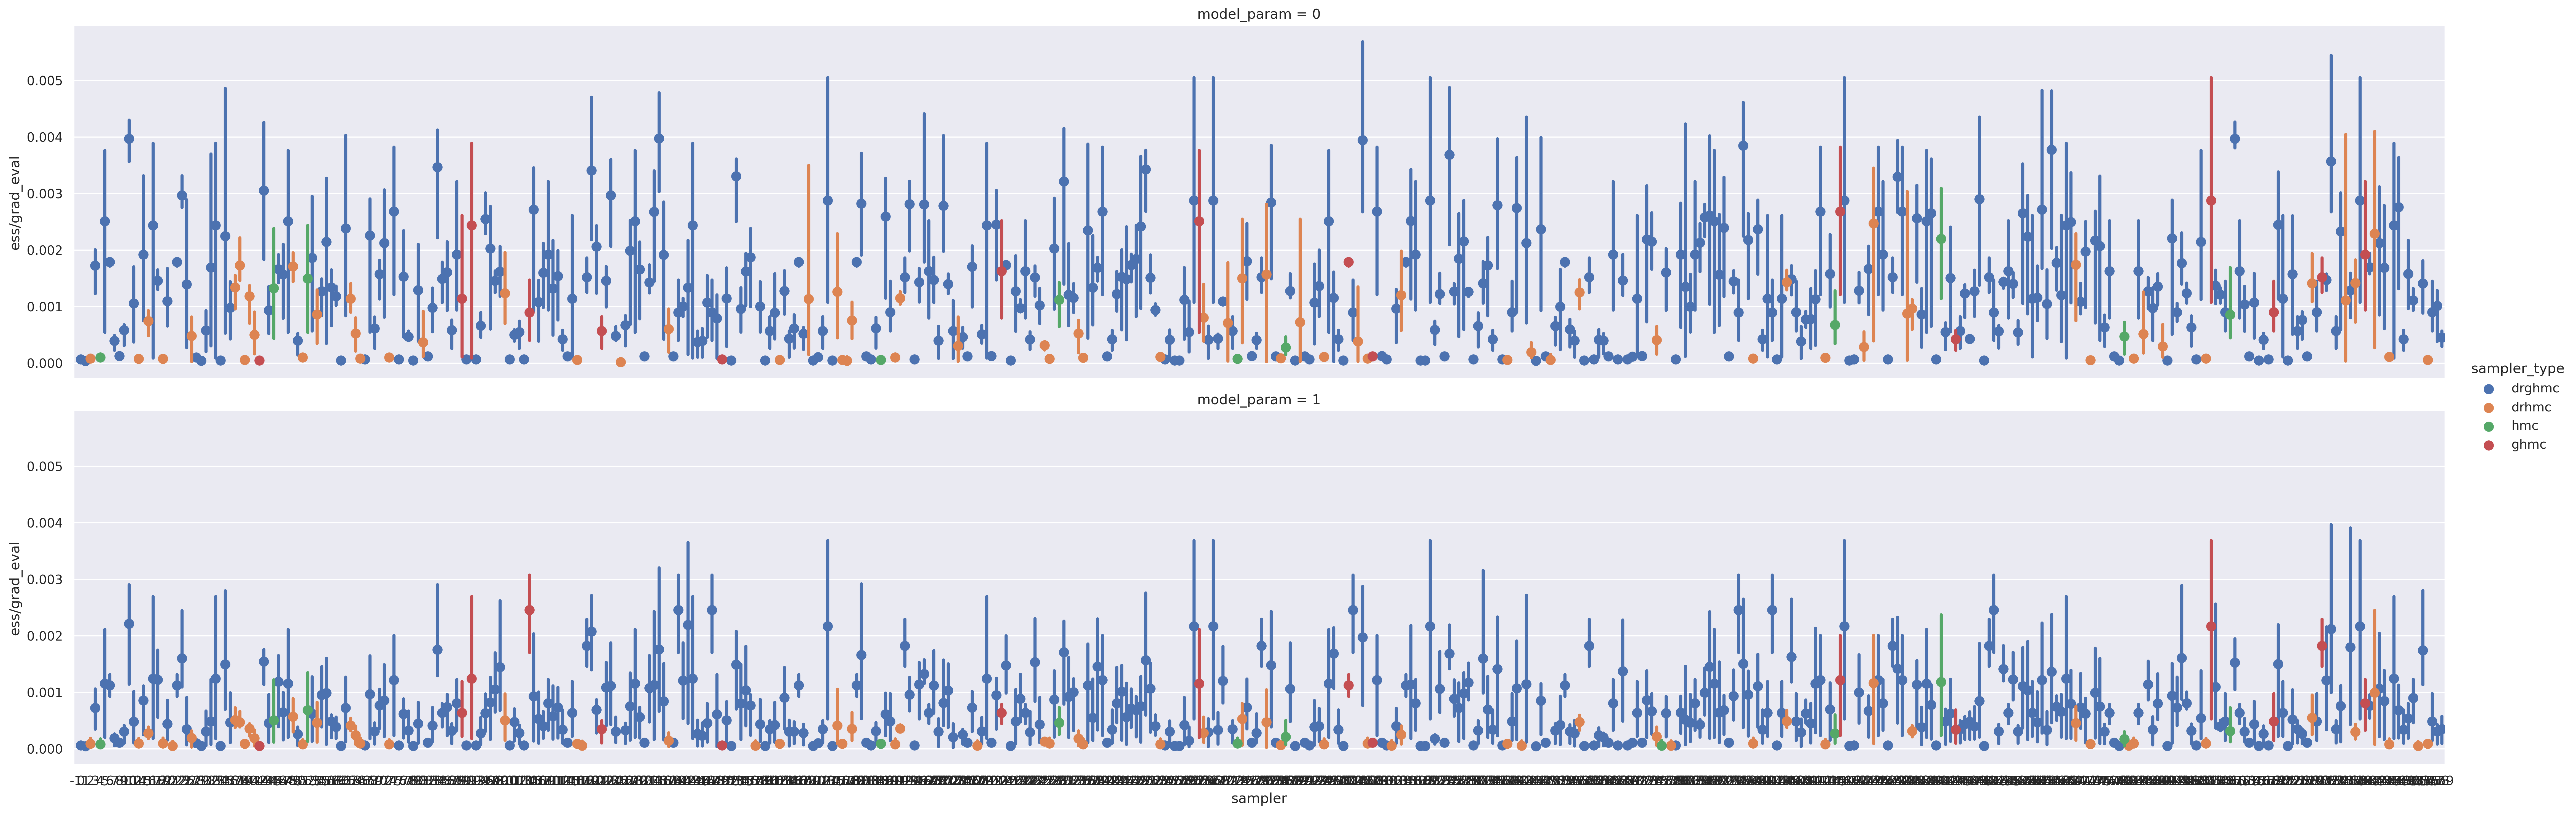

In [63]:
_ = sns.catplot(data=df, x="sampler", y="ess/grad_eval", legend=True, aspect=6, join=False,
                kind="point", row="model_param", hue="sampler_type", dodge=True, errorbar=("pi", 100))

In [65]:
_ = sns.catplot(data=df, x="sampler", y="ess/grad_eval", legend=True, aspect=6, join=False,
                kind="point", row="sampler_type", hue="model_param", dodge=True, errorbar=("pi", 100))

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [93]:
# model param 1 has worst ESS for funnel 2
# model param 0 has worst ESS for funnel 10


print("\t\tESS/Grad Eval\t\t     ESS^2/Grad Eval")

for model_param in range(num_model_params):
    model_param_df = df[df["model_param"] == model_param]
 
    df1 = model_param_df[(model_param_df["sampler_type"] == "hmc")]
    print(f"HMC\t{model_param}: ", df1["ess/grad_eval"].max(), "\t", df1["ess^2/grad_eval"].max())

    df2 = model_param_df[(model_param_df["sampler_type"] == "drhmc")]
    print(f"DRHMC\t{model_param}: ", df2["ess/grad_eval"].max(), "\t", df2["ess^2/grad_eval"].max())

    df3 = model_param_df[(model_param_df["sampler_type"] == "ghmc")]
    print(f"GHMC\t{model_param}: ", df3["ess/grad_eval"].max(), "\t", df3["ess^2/grad_eval"].max())

    df4 = model_param_df[(model_param_df["sampler_type"] == "drghmc")]
    print(f"DRGHMC\t{model_param}: ", df4["ess/grad_eval"].max(), "\t", df4["ess^2/grad_eval"].max())
    
    print()

		ESS/Grad Eval		     ESS^2/Grad Eval
HMC	0:  0.0030985705885683986 	 0.004477826826889257
DRHMC	0:  0.004101308220166952 	 0.004171507810587624
GHMC	0:  0.0050543896005826195 	 0.0049172296843101254
DRGHMC	0:  0.005687401028385257 	 0.006902776520330675

HMC	1:  0.002372498478277766 	 0.0020004055937501786
DRHMC	1:  0.0024512903498609025 	 0.0018447396543731633
GHMC	1:  0.0036856234581840158 	 0.0030612030014584624
DRGHMC	1:  0.003966262311486294 	 0.003407414630663333



In [92]:
# samplers with 20 highest ess/grad_eval
n = 20

hmc_idx = ( df["sampler_type"] == "hmc" )
drhmc_idx = ( df["sampler_type"] == "drhmc" )
best_df = df[ (df[hmc_idx].nlargest(20, "ess/grad_eval")), (df[drhmc_idx].nlargest(20, "ess/grad_eval")) ]
best_df

InvalidIndexError: (      model_param  sampler  chain      mean       std  ess/grad_eval  \
3532            0      441      2  0.047593  2.733753       0.003099   
3530            0      441      1 -0.052853  2.789856       0.002442   
422             0       52      3  0.064219  2.738684       0.002442   
362             0       45      1 -0.060186  2.787433       0.002385   
3531            1      441      1  0.106087  3.610383       0.002372   
3528            0      441      0  0.125613  2.867278       0.002127   
418             0       52      1 -0.087781  2.808310       0.001815   
4056            0      507      0  0.035283  2.730950       0.001693   
366             0       45      3  0.158155  2.860058       0.001646   
3533            1      441      2  0.158026  3.770420       0.001549   
1842            0      230      1 -0.114559  2.828298       0.001431   
1846            0      230      3 -0.185518  2.888525       0.001415   
419             1       52      1 -0.090593  3.468942       0.001350   
3322            0      415      1 -0.135435  2.774751       0.001285   
363             1       45      1 -0.074926  3.971153       0.001222   
416             0       52      0  0.140880  2.904387       0.001182   
3534            0      441      3  0.196392  2.884477       0.001143   
1844            0      230      2  0.098810  2.929974       0.000990   
423             1       52      3 -0.046649  4.214025       0.000862   
360             0       45      0  0.175678  2.960885       0.000849   

      ess^2/grad_eval  init_stepsize  reduction_factor steps  dampening  \
3532         0.004478           0.10               2.0    50        0.0   
3530         0.002585           0.10               2.0    50        0.0   
422          0.002643           0.10               2.0    20        0.0   
362          0.002541           0.10               2.0    30        0.0   
3531         0.002000           0.10               2.0    50        0.0   
3528         0.001267           0.10               2.0    50        0.0   
418          0.001609           0.10               2.0    20        0.0   
4056         0.002764           0.10               2.0    10        0.0   
366          0.001338           0.10               2.0    30        0.0   
3533         0.001324           0.10               2.0    50        0.0   
1842         0.001848           0.05               2.0    50        0.0   
1846         0.002114           0.05               2.0    50        0.0   
419          0.001170           0.10               2.0    20        0.0   
3322         0.002273           0.05               2.0    30        0.0   
363          0.000925           0.10               2.0    30        0.0   
416          0.001163           0.10               2.0    20        0.0   
3534         0.000509           0.10               2.0    50        0.0   
1844         0.001065           0.05               2.0    50        0.0   
423          0.000775           0.10               2.0    20        0.0   
360          0.000406           0.10               2.0    30        0.0   

      num_proposals sampler_type  chain_length  grad_evals  accept_total  \
3532            1.0          hmc       10000.0    500000.0      0.952800   
3530            1.0          hmc       10000.0    500000.0      0.943000   
422             1.0          hmc       25000.0    500000.0      0.973960   
362             1.0          hmc       16666.0    499980.0      0.958478   
3531            1.0          hmc       10000.0    500000.0      0.943000   
3528            1.0          hmc       10000.0    500000.0      0.947300   
418             1.0          hmc       25000.0    500000.0      0.957760   
4056            1.0          hmc       50000.0    500000.0      0.979620   
366             1.0          hmc       16666.0    499980.0      0.969759   
3533            1.0          hmc       10000.0    500000.0      0.952800   
1842            1.0          hmc       10000.0    500000.0      0.984300   
1846            1.0          hmc       10000.0    500000.0      0.983400   
419             1.0          hmc       25000.0    500000.0      0.957760   
3322            1.0          hmc       16666.0    499980.0      0.990580   
363             1.0          hmc       16666.0    499980.0      0.958478   
416             1.0          hmc       25000.0    500000.0      0.970640   
3534            1.0          hmc       10000.0    500000.0      0.959000   
1844            1.0          hmc       10000.0    500000.0      0.988400   
423             1.0          hmc       25000.0    500000.0      0.973960   
360             1.0          hmc       16666.0    499980.0      0.964179   

      accept_0                                     sampler_params      rhat  \
3532  0.952800  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000669   
3530  0.943000  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000669   
422   0.973960  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000561   
362   0.958478  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.001072   
3531  0.943000  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000722   
3528  0.947300  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000669   
418   0.957760  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000561   
4056  0.979620  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000989   
366   0.969759  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.001072   
3533  0.952800  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000722   
1842  0.984300  init_stepsize: 0.05\nreduction_factor: 2\nstep...  1.000920   
1846  0.983400  init_stepsize: 0.05\nreduction_factor: 2\nstep...  1.000920   
419   0.957760  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.002915   
3322  0.990580  init_stepsize: 0.05\nreduction_factor: 2\nstep...  1.001172   
363   0.958478  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.002615   
416   0.970640  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000561   
3534  0.959000  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000669   
1844  0.988400  init_stepsize: 0.05\nreduction_factor: 2\nstep...  1.000920   
423   0.973960  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.002915   
360   0.964179  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.001072   

      accept_1  accept_2  accept_3  
3532       NaN       NaN       NaN  
3530       NaN       NaN       NaN  
422        NaN       NaN       NaN  
362        NaN       NaN       NaN  
3531       NaN       NaN       NaN  
3528       NaN       NaN       NaN  
418        NaN       NaN       NaN  
4056       NaN       NaN       NaN  
366        NaN       NaN       NaN  
3533       NaN       NaN       NaN  
1842       NaN       NaN       NaN  
1846       NaN       NaN       NaN  
419        NaN       NaN       NaN  
3322       NaN       NaN       NaN  
363        NaN       NaN       NaN  
416        NaN       NaN       NaN  
3534       NaN       NaN       NaN  
1844       NaN       NaN       NaN  
423        NaN       NaN       NaN  
360        NaN       NaN       NaN  ,       model_param  sampler  chain         mean         std  ess/grad_eval  \
4340            0      542      2    -0.026410    2.721678       0.004101   
4294            0      536      3  1431.419312  127.800423       0.004048   
1354            0      169      1  1508.175049  108.427948       0.003502   
3398            0      424      3     0.045773    2.879938       0.003452   
3396            0      424      2    -0.017499    2.846423       0.003357   
3474            0      434      1  1437.118774  129.062027       0.003039   
2258            0      282      1     0.046913    2.869099       0.002818   
4342            0      542      3     0.099660    2.802380       0.002705   
3394            0      424      1     0.012474    2.877355       0.002696   
2204            0      275      2    -0.009221    2.890388       0.002553   
2320            0      290      0  1548.430054  129.678802       0.002550   
2202            0      275      1     0.005159    2.935164       0.002509   
4341            1      542      2    -0.056135    3.768672       0.002451   
1414            0      176      3    -0.071764    2.868839       0.002296   
3764            0      470      2    -0.028533    2.875304       0.002292   
310             0       38      3    -0.070402    2.999888       0.002219   
4338            0      542      1     0.089612    2.824123       0.002094   
3766            0      470      3     0.022079    2.934288       0.002021   
3399            1      424      3     0.005557    4.387291       0.002015   
2518            0      314      3    -0.073642    2.902370       0.001984   

      ess^2/grad_eval  init_stepsize  reduction_factor steps  dampening  \
4340         0.004172            0.2               2.0    30        0.0   
4294         0.004048            0.2               2.0    20        0.0   
1354         0.003502            0.2               2.0    10        0.0   
3398         0.003772            0.2               4.0    30        0.0   
3396         0.003996            0.2               4.0    30        0.0   
3474         0.003039            0.2               4.0    20        0.0   
2258         0.003249            0.2               2.0    30        0.0   
4342         0.002256            0.2               2.0    30        0.0   
3394         0.003206            0.2               4.0    30        0.0   
2204         0.001778            0.2               5.0    30        0.0   
2320         0.002550            0.2               2.0    10        0.0   
2202         0.002501            0.2               5.0    30        0.0   
4341         0.001845            0.2               2.0    30        0.0   
1414         0.003188            0.1               2.0    50        0.0   
3764         0.001586            0.1               4.0    50        0.0   
310          0.002801            0.1               5.0    50        0.0   
4338         0.001681            0.2               2.0    30        0.0   
3766         0.001932            0.1               4.0    50        0.0   
3399         0.001841            0.2               4.0    30        0.0   
2518         0.001395            0.2               4.0    30        0.0   

      num_proposals sampler_type  chain_length  grad_evals  accept_total  \
4340            2.0        drhmc       16666.0    725285.0      0.917737   
4294            3.0        drhmc       25000.0     31197.0      0.007640   
1354            4.0        drhmc       50000.0     55559.0      0.004940   
3398            2.0        drhmc       16666.0    861736.0      0.942818   
3396            2.0        drhmc       16666.0    888363.0      0.942098   
3474            4.0        drhmc       25000.0     41130.0      0.007840   
2258            3.0        drhmc       16666.0    994556.0      0.941738   
4342            2.0        drhmc       16666.0    714757.0      0.923497   
3394            2.0        drhmc       16666.0    881504.0      0.942758   
2204            2.0        drhmc       16666.0    940047.0      0.943598   
2320            3.0        drhmc       50000.0     56341.0      0.006560   
2202            2.0        drhmc       16666.0    951182.0      0.945878   
4341            2.0        drhmc       16666.0    725285.0      0.917737   
1414            3.0        drhmc       10000.0    676332.0      0.974400   
3764            2.0        drhmc       10000.0    652605.0      0.975400   
310             2.0        drhmc       10000.0    693566.0      0.970100   
4338            2.0        drhmc       16666.0    720095.0      0.921217   
3766            2.0        drhmc       10000.0    644356.0      0.978000   
3399            2.0        drhmc       16666.0    861736.0      0.942818   
2518            3.0        drhmc       16666.0   1377319.0      0.947378   

      accept_0                                     sampler_params      rhat  \
4340  0.847054  init_stepsize: 0.2\nreduction_factor: 2\nsteps...  1.000371   
4294  0.007160  init_stepsize: 0.2\nreduction_factor: 2\nsteps...  1.029040   
1354  0.004600  init_stepsize: 0.2\nreduction_factor: 2\nsteps...  1.029343   
3398  0.844954  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000231   
3396  0.837574  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000231   
3474  0.006640  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.017217   
2258  0.843694  init_stepsize: 0.2\nreduction_factor: 2\nsteps...  1.017688   
4342  0.853654  init_stepsize: 0.2\nreduction_factor: 2\nsteps...  1.000371   
3394  0.840274  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000231   
2204  0.841714  init_stepsize: 0.2\nreduction_factor: 5\nsteps...  1.000507   
2320  0.005980  init_stepsize: 0.2\nreduction_factor: 2\nsteps...  1.040566   
2202  0.839434  init_stepsize: 0.2\nreduction_factor: 5\nsteps...  1.000507   
4341  0.847054  init_stepsize: 0.2\nreduction_factor: 2\nsteps...  1.005445   
1414  0.940600  init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000376   
3764  0.936100  init_stepsize: 0.1\nreduction_factor: 4\nsteps...  1.000011   
310   0.928100  init_stepsize: 0.1\nreduction_factor: 5\nsteps...  1.000114   
4338  0.849094  init_stepsize: 0.2\nreduction_factor: 2\nsteps...  1.000371   
3766  0.940100  init_stepsize: 0.1\nreduction_factor: 4\nsteps...  1.000011   
3399  0.844954  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.003129   
2518  0.836613  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000187   

      accept_1  accept_2  accept_3  
4340  0.465245       NaN       NaN  
4294  0.500000  0.200000       NaN  
1354  0.481481  0.285714       0.0  
3398  0.667622       NaN       NaN  
3396  0.666157       NaN       NaN  
3474  0.735294  0.555556       0.0  
2258  0.470937  0.332084       NaN  
4342  0.481988       NaN       NaN  
3394  0.664591       NaN       NaN  
2204  0.682476       NaN       NaN  
2320  0.413043  0.370370       NaN  
2202  0.696506       NaN       NaN  
4341  0.465245       NaN       NaN  
1414  0.493955  0.177474       NaN  
3764  0.636953       NaN       NaN  
310   0.637329       NaN       NaN  
4338  0.484482       NaN       NaN  
3766  0.650086       NaN       NaN  
3399  0.667622       NaN       NaN  
2518  0.659930  0.170115       NaN  )

In [37]:
model_param = 0

In [ ]:
# df["sampler2"] = df["init_stepsize"].astype(str) + df["reduction_factor"].astype(str) + df["steps"].astype(str) + df["dampening"].astype(str)


stats_fig1 = sns.catplot(data=df, x="sampler", y="ess/grad_eval",
                        legend=True, hue="sampler_type", aspect=6)

stats_fig2 = sns.catplot(data=df, x="sampler", y="ess^2/grad_eval",
                        legend=True, hue="sampler_type", aspect=6)

In [27]:
df = stats[stats["model_param"] == model_param] # examine a single model param
df = df[np.abs(df["rhat"] - 1) < 0.1] # good rhat
df = df[np.abs(df["mean"] - REF_MEAN[model_param]) < 5] # good mean
df = df.nlargest(100, "ess/grad_eval") # good ess/grad_eval
df = df.sort_values(by=["ess/grad_eval"], ascending=False) # sort df
# df["steps"].apply(lambda x: x if isinstance(x, int) else -1) # convert "const_stepsize" to -1 
df

model_param  sampler  chain      mean       std  ess/grad_eval  \
2452            0      306      2  0.062433  2.846639       0.005687   
4266            0      533      1 -0.035268  2.860223       0.005450   
1398            0      174      3  0.037761  2.734170       0.005054   
2102            0      262      3  0.037761  2.734170       0.005054   
2142            0      267      3  0.037761  2.734170       0.005054   
...           ...      ...    ...       ...       ...            ...   
2724            0      340      2 -0.078588  2.904744       0.003638   
3516            0      439      2  0.011543  2.868762       0.003614   
1234            0      154      1 -0.025878  2.969457       0.003613   
996             0      124      2 -0.024645  2.845518       0.003607   
82              0       10      1 -0.080078  2.954786       0.003564   

      ess^2/grad_eval  init_stepsize  reduction_factor           steps  \
2452         0.005050            0.2               4.0               1   
4266         0.006903            0.2               4.0               1   
1398         0.004394            0.2               5.0               1   
2102         0.004394            0.2               4.0  const_traj_len   
2142         0.004394            0.2               4.0               1   
...               ...            ...               ...             ...   
2724         0.005157            0.1               5.0  const_traj_len   
3516         0.002897            0.2               4.0               1   
1234         0.003437            0.2               4.0               1   
996          0.004488            0.1               2.0               1   
82           0.002065            0.2               5.0               1   

      dampening  num_proposals sampler_type  chain_length  grad_evals  \
2452       0.10            2.0       drghmc      500000.0    565442.0   
4266       0.05            2.0       drghmc      500000.0    570526.0   
1398       0.05            1.0       drghmc      500000.0    500000.0   
2102       0.05            1.0       drghmc      500000.0    500000.0   
2142       0.05            1.0       drghmc      500000.0    500000.0   
...         ...            ...          ...           ...         ...   
2724       0.05            2.0       drghmc      500000.0    573385.0   
3516       0.20            3.0       drghmc      500000.0    600896.0   
1234       0.05            4.0       drghmc      500000.0    652318.0   
996        0.05            3.0       drghmc      500000.0    543802.0   
82         0.05            3.0       drghmc      500000.0    614974.0   

      accept_total  accept_0  \
2452      0.982150  0.934558   
4266      0.980474  0.929474   
1398      0.945586  0.945586   
2102      0.945586  0.945586   
2142      0.945586  0.945586   
...            ...       ...   
2724      0.986594  0.970646   
3516      0.985446  0.931242   
1234      0.984982  0.924034   
996       0.991540  0.976196   
82        0.983514  0.923742   

                                         sampler_params      rhat  accept_1  \
2452  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000205  0.727239   
4266  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000092  0.723138   
1398  init_stepsize: 0.2\nreduction_factor: 5\nsteps...  1.000151       NaN   
2102  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000151       NaN   
2142  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000151       NaN   
...                                                 ...       ...       ...   
2724  init_stepsize: 0.1\nreduction_factor: 5\nsteps...  1.000304  0.543299   
3516  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000308  0.724163   
1234  init_stepsize: 0.2\nreduction_factor: 4\nsteps...  1.000106  0.686886   
996   init_stepsize: 0.1\nreduction_factor: 2\nsteps...  1.000398  0.511007   
82    init_stepsize: 0.2\nreduction_factor: 5\nsteps...  1.000531  0.702405   

      accept_2  accept_3  
2452       NaN

In [30]:
plot_stats(df)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [35]:
print("\t\tESS/Grad Eval\t\tESS^2/Grad Eval")

df1 = stats[(stats["sampler_type"] == "hmc")]
print("HMC:\t", df1["ess/grad_eval"].max(), df1["ess^2/grad_eval"].max())

df2 = stats[(stats["sampler_type"] == "drhmc")]
print("DRHMC:\t", df2["ess/grad_eval"].max(), df2["ess^2/grad_eval"].max())

df3 = stats[(stats["sampler_type"] == "ghmc")]
print("GHMC:\t", df3["ess/grad_eval"].max(), df3["ess^2/grad_eval"].max())

df4 = stats[(stats["sampler_type"] == "drghmc")]
print("DRGHMC:\t", df4["ess/grad_eval"].max(), df4["ess^2/grad_eval"].max())

		ESS/Grad Eval		ESS^2/Grad Eval
HMC:	 0.0030985705885683986 0.004477826826889257
DRHMC:	 0.1069207187698934 0.10691991452661494
GHMC:	 0.0050543896005826195 0.0049172296843101254
DRGHMC:	 0.005687401028385257 0.006902776520330675


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


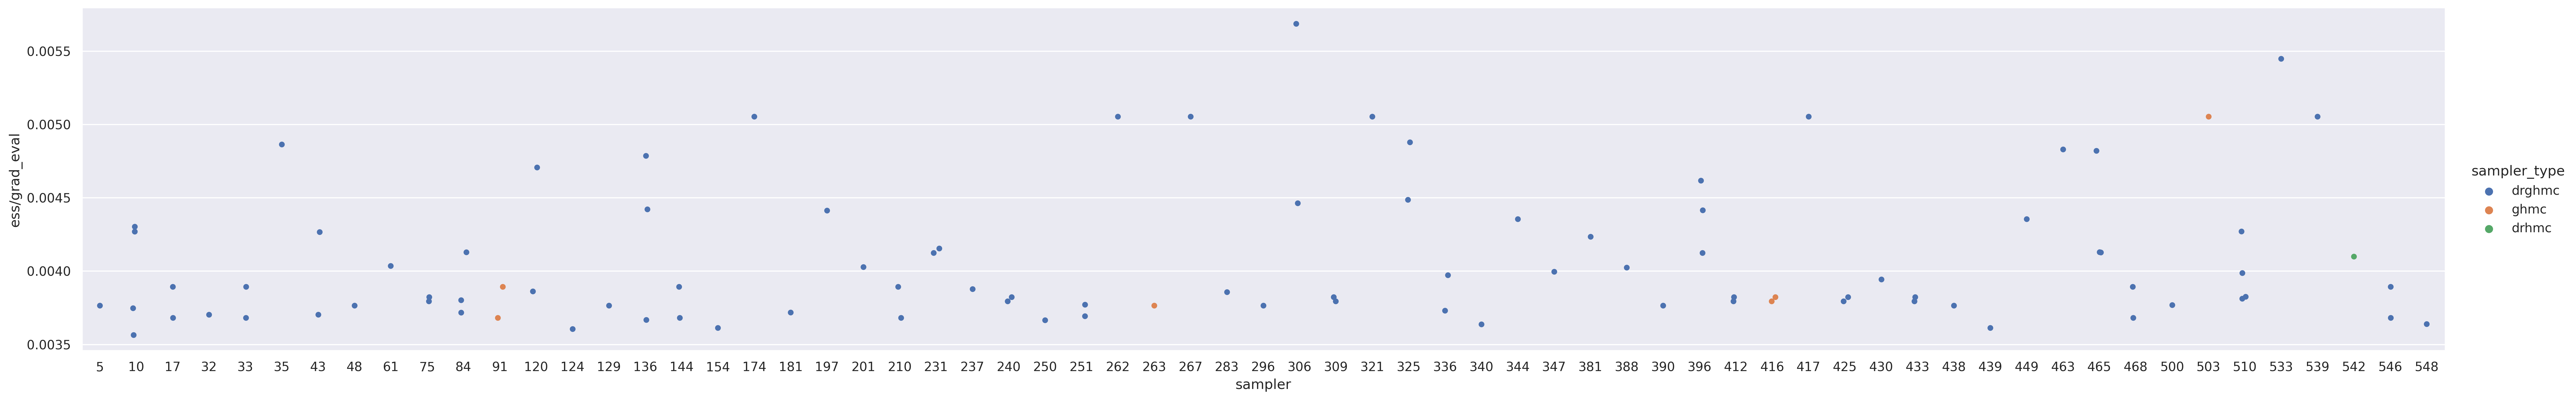

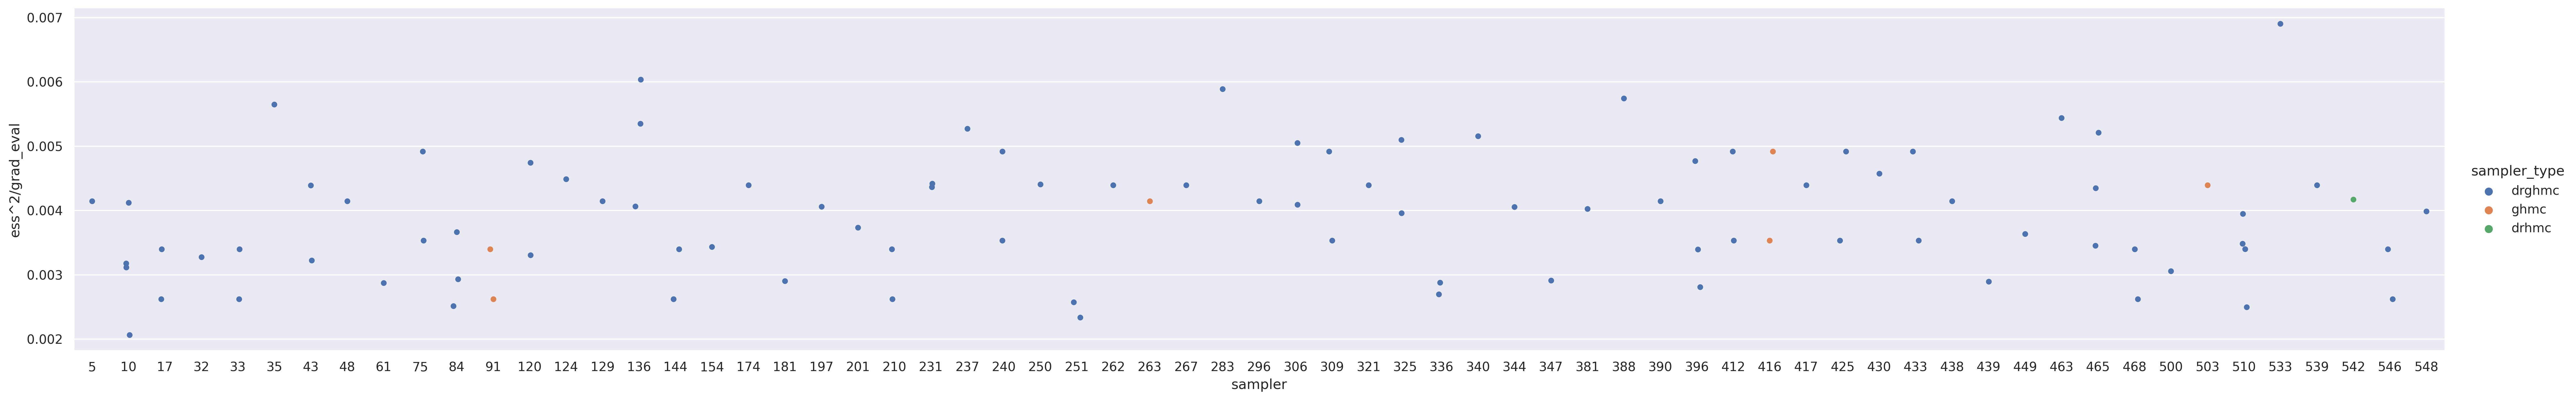

In [32]:
# df["sampler2"] = df["init_stepsize"].astype(str) + df["reduction_factor"].astype(str) + df["steps"].astype(str) + df["dampening"].astype(str)

stats_fig1 = sns.catplot(data=df, x="sampler", y="ess/grad_eval",
                        legend=True, hue="sampler_type", aspect=6)

stats_fig2 = sns.catplot(data=df, x="sampler", y="ess^2/grad_eval",
                        legend=True, hue="sampler_type", aspect=6)

# Investigating DRGHMC

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


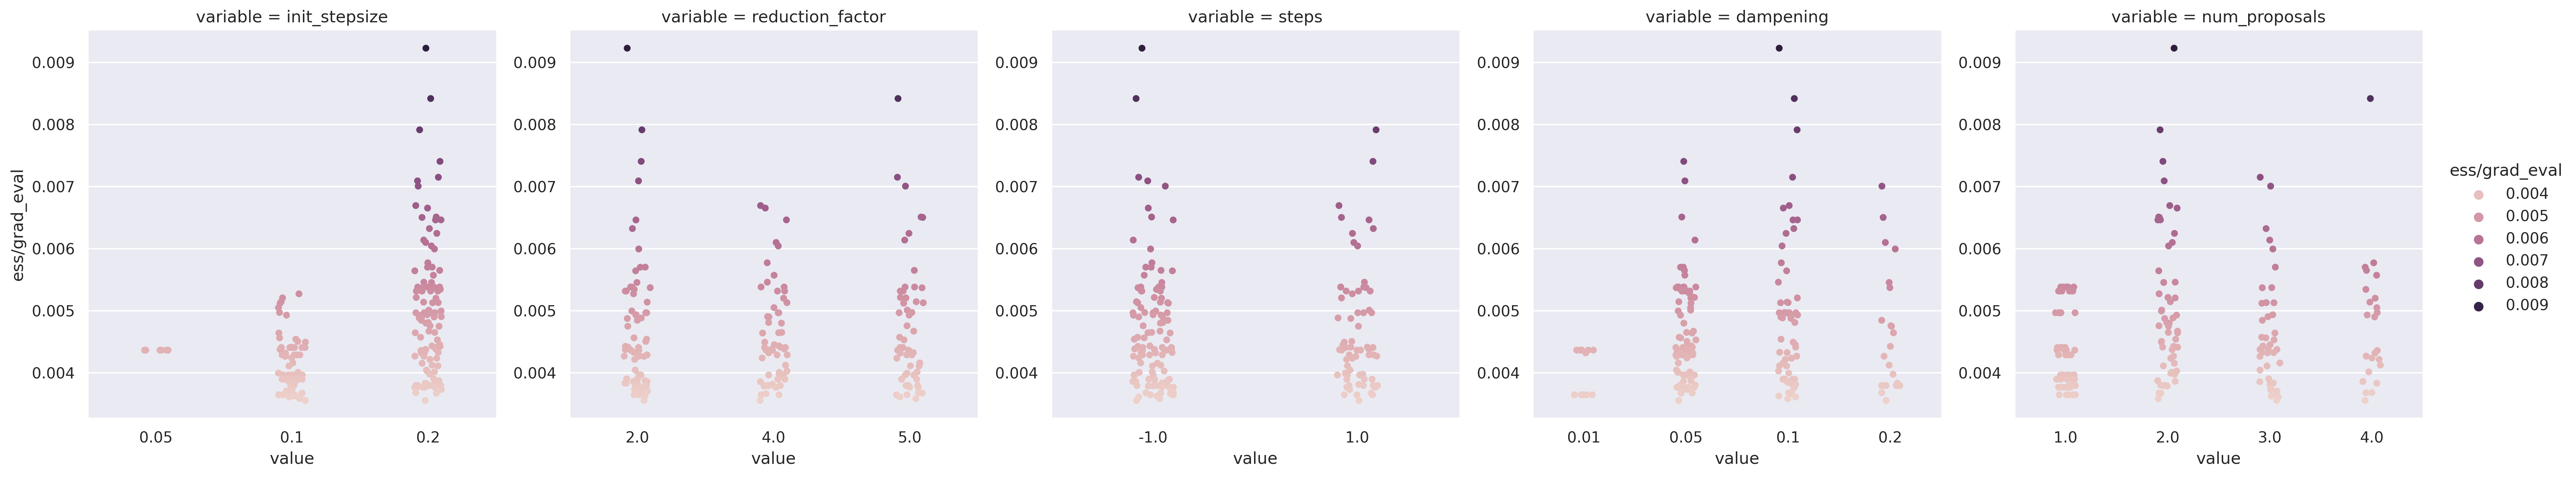

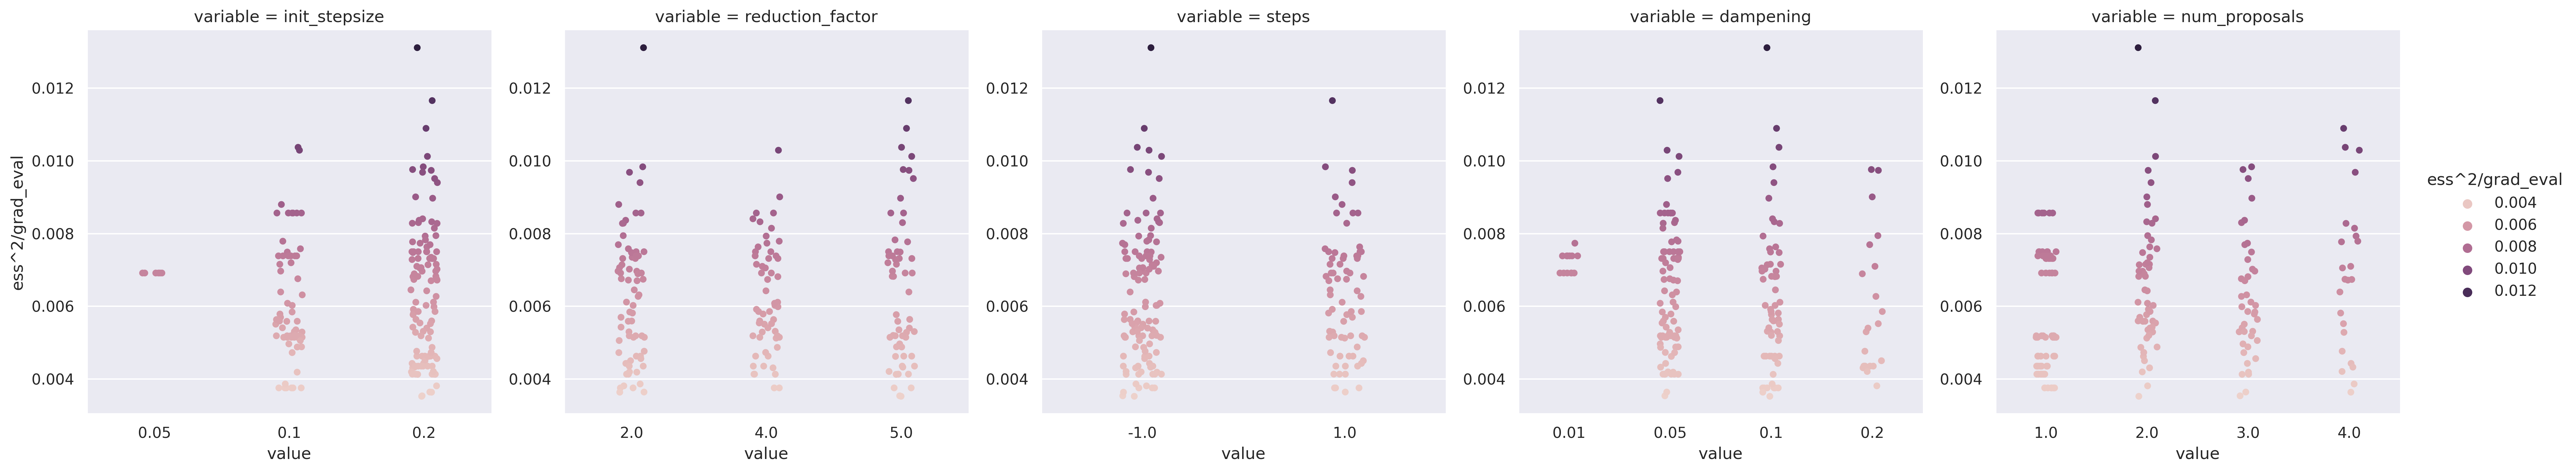

In [47]:
# for samplers with good ess/grad_eval, how does init_stepsize, reduction_factor, steps, dampening, and num_proposals affect ess/grad_eval?
melted = pd.melt(df, id_vars=["ess/grad_eval", "ess^2/grad_eval", "sampler_type"], value_vars=["init_stepsize", "reduction_factor", "steps", "dampening", "num_proposals"])

stats_fig1 = sns.catplot(data=melted, x="value", y="ess/grad_eval",
                        col="variable", hue="ess/grad_eval",
                        sharex=False, sharey=False,
                        legend=True,)

stats_fig2 = sns.catplot(data=melted, x="value", y="ess^2/grad_eval",
                        col="variable", hue="ess^2/grad_eval",
                        sharex=False, sharey=False,
                        legend=True,)

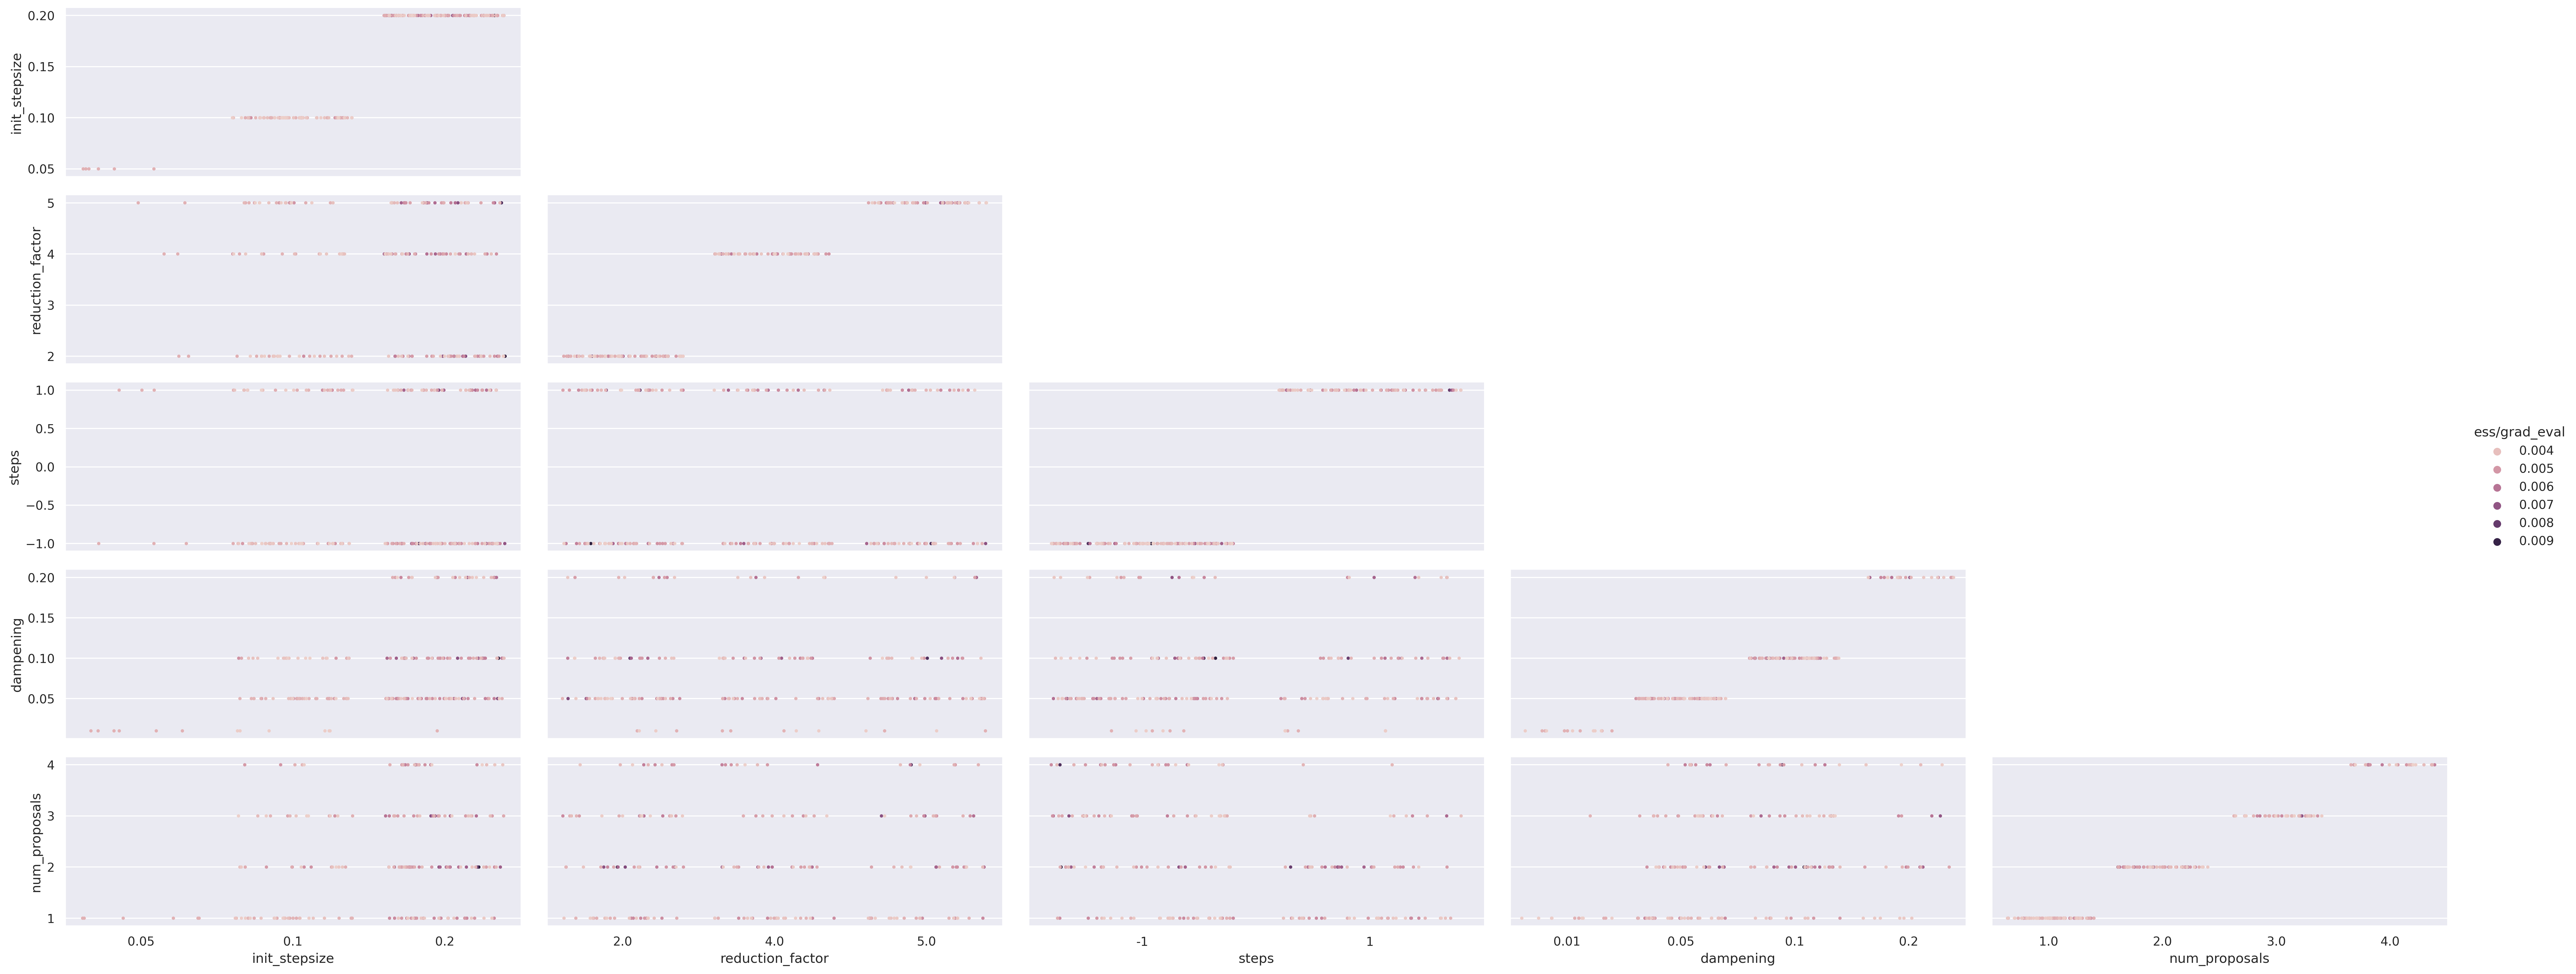

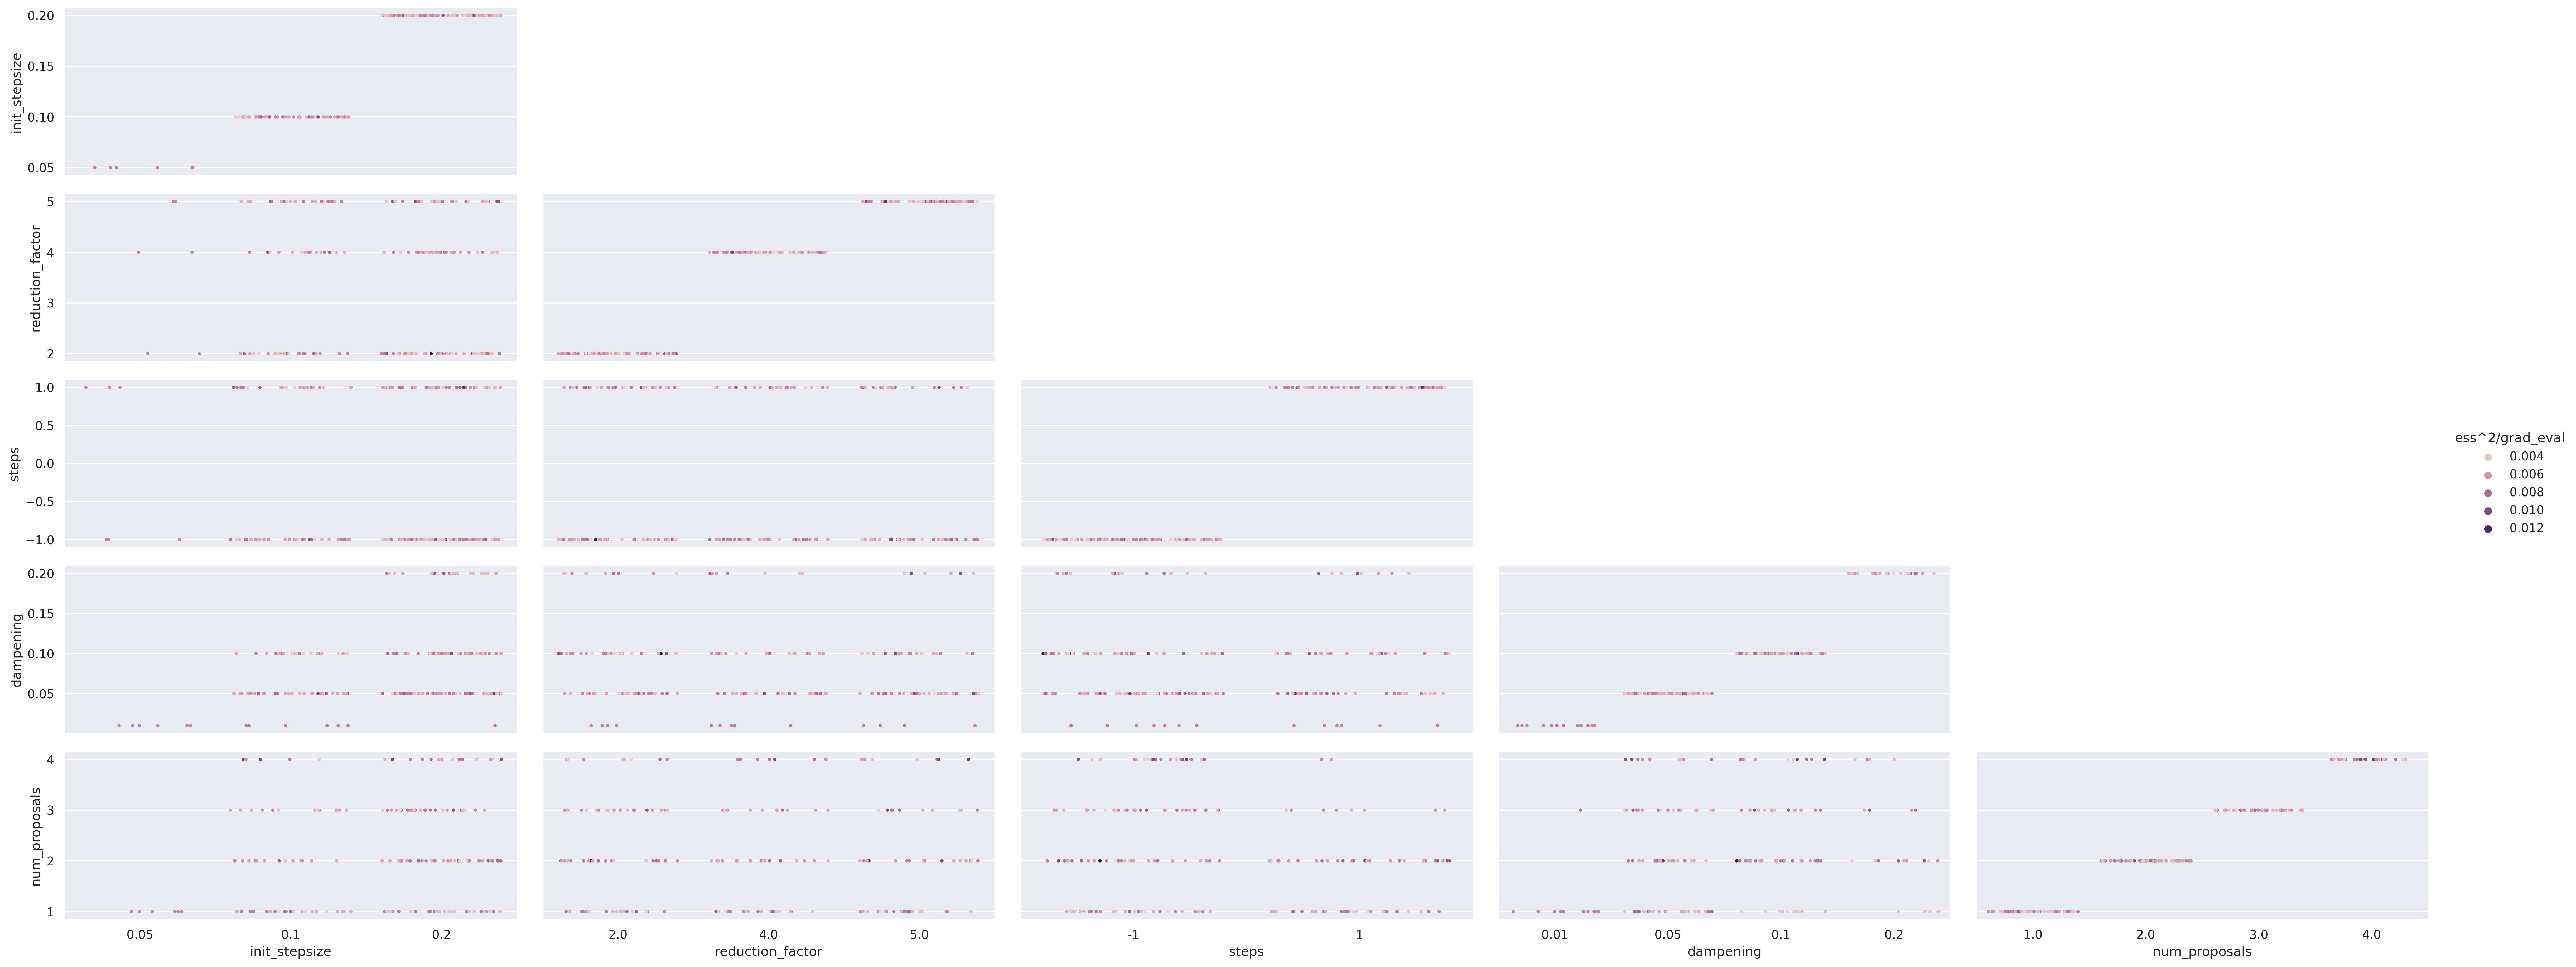

In [46]:
df["steps"].replace("const_stepsize", -1, inplace=True)
pd.to_numeric(df["steps"])

g = sns.PairGrid(df, corner=True, hue="ess/grad_eval", aspect=2.5,
                 vars=["init_stepsize", "reduction_factor", "steps", "dampening", "num_proposals"])
g.map(sns.stripplot, size=3, jitter=0.4, legend=True)
g.add_legend()

g = sns.PairGrid(df, corner=True, hue="ess^2/grad_eval", aspect=2.5,
                 vars=["init_stepsize", "reduction_factor", "steps", "dampening", "num_proposals"])
g.map(sns.stripplot, size=3, jitter=0.4, legend=True)
g.add_legend()

# Evaluatation

In [7]:
def eval(num_samplers, num_chains, num_model_params, num_ref_chains):
    hist_fig, hist_axes = plt.subplots(nrows=num_model_params, ncols=num_chains, sharex="row", sharey="row",
                                       figsize=(num_chains*4.5, num_model_params*3.5,), 
    )
    chain_fig, chain_axes = plt.subplots(nrows=num_model_params, ncols=num_samplers, sharey="row",
                                         figsize=(num_samplers*3, num_model_params*4),
    )
    stats_df_list = []
    for sampler in trange(num_samplers):
        rhat_dict = defaultdict(list)
        for chain in range(num_chains):
            
            all_draws, all_burned_draws, sampler_params = extract_my_data(sampler, chain)
            for model_param in range(num_model_params):
                # pre-processing
                draws, burned_draws = all_draws[:, model_param], all_burned_draws[:, model_param]
                rhat_dict[model_param].append(draws)
                
                # histogram plotting
                sns.histplot(draws, ax=hist_axes[model_param, chain], 
                             stat="density", fill=False, element="step", linewidth=0.5,
                             label=f"sampler {sampler}" if model_param + chain == 0 else "",
                ).set_title(f"Model Param {model_param} | Chain {chain}")
                
                # chains plotting
                x = np.arange(sampler_params["burn_in"])
                sns.lineplot(x=x, y=burned_draws, ax=chain_axes[model_param, sampler], 
                             linewidth=0.2,
                             label=f"chain {chain}" if sampler + model_param == 0 else "",
                ).set_title(f"Model Param {model_param} | Sampler {sampler}")
                x = np.arange(sampler_params["burn_in"], sampler_params["burn_in"] + sampler_params["chain_length"])
                sns.lineplot(x=x, y=draws, ax=chain_axes[model_param, sampler],
                            linewidth=0.2, color=chain_axes[model_param, sampler].get_lines()[-1].get_color(),
                )
                chain_axes[model_param, sampler].axvline(x=sampler_params["burn_in"], color="black")
                
                # stats dataframe
                stats_row = {
                    "model_param": model_param,
                    "sampler": sampler,
                    "chain": chain,
                    "mean": np.mean(draws),
                    "std": np.std(draws),
                    "ess/grad_eval": ess(draws) / sampler_params["grad_evals"],
                    "ess^2/grad_eval": ess(draws**2) / sampler_params["grad_evals"],
                }
                for k, v in sampler_params.items():
                    stats_row[k] = v
                stats_row["sampler_params"] = "\n".join(f"{k}: {v}" for k, v in sampler_params.items())
                stats_df_list.append(stats_row)
                
        # stats dataframe
        for model_param in range(num_model_params):
            rhat_val = rhat(rhat_dict[model_param])
            for chain in range(num_chains):
                idx = (sampler * num_chains * num_model_params) + (chain * num_model_params) + model_param
                stats_row = stats_df_list[idx]
                stats_row["rhat"] = rhat_val
                
    # reference draws
    ref_dict = defaultdict(list)
    for chain in range(num_ref_chains):
        all_ref_draws = get_ref_draws(chain)
        for model_param in range(num_model_params):
            # pre-processing
            ref_draws = all_ref_draws[:, model_param]
            ref_dict[model_param].append(ref_draws)
            
            # histplot
            sns.histplot(ref_draws, ax=hist_axes[model_param, chain], 
                         stat="density", fill=False, element="step", linewidth=1.5, color="black",
                         label="ref" if model_param + chain == 0 else "",
            )
            
            # stats dataframe
            stats_row = {
                "model_param": model_param,
                "sampler": -1,
                "chain": chain,
                "mean": np.mean(ref_draws),
                "std": np.std(ref_draws),
            }
            stats_df_list.append(stats_row)
    
    # stats dataframe
    for model_param in range(num_model_params):
        rhat_val = rhat(ref_dict[model_param])
        for chain in range(num_chains):
            idx = idx = (num_samplers * num_chains * num_model_params) + (chain * num_model_params) + model_param
            stats_row = stats_df_list[idx]
            stats_row["rhat"] = rhat_val
            
    # stats post-processing
    stats_df = pd.DataFrame(stats_df_list).sort_values(by=["model_param", "sampler", "chain"])
    stats_fig = plot_stats_df(stats_df, num_samplers)
    
    # histogram post-processing
    hist_fig.legend(loc="upper right")
    hist_fig.tight_layout()
    hist_fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "histogram.svg")
    hist_fig.savefig(hist_fname)
    hist_fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "histogram.pdf")
    hist_fig.savefig(hist_fname)
    
    # chain post-processing
    chain_fig.legend(loc="upper right")
    chain_fig.tight_layout()
    chain_fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "chain.svg")
    chain_fig.savefig(chain_fname)
    chain_fname = os.path.join(FIGURE_DIR, f"model_{MODEL_NUM:02d}", "chain.pdf")
    chain_fig.savefig(chain_fname)
                               
    return hist_fig, chain_fig, stats_fig, stats_df

100%|██████████| 288/288 [41:12<00:00,  8.58s/it]


ValueError: Image size of 216000x7500 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x15550da1b420> (for post_execute):


ValueError: Image size of 259200x6000 pixels is too large. It must be less than 2^16 in each direction.

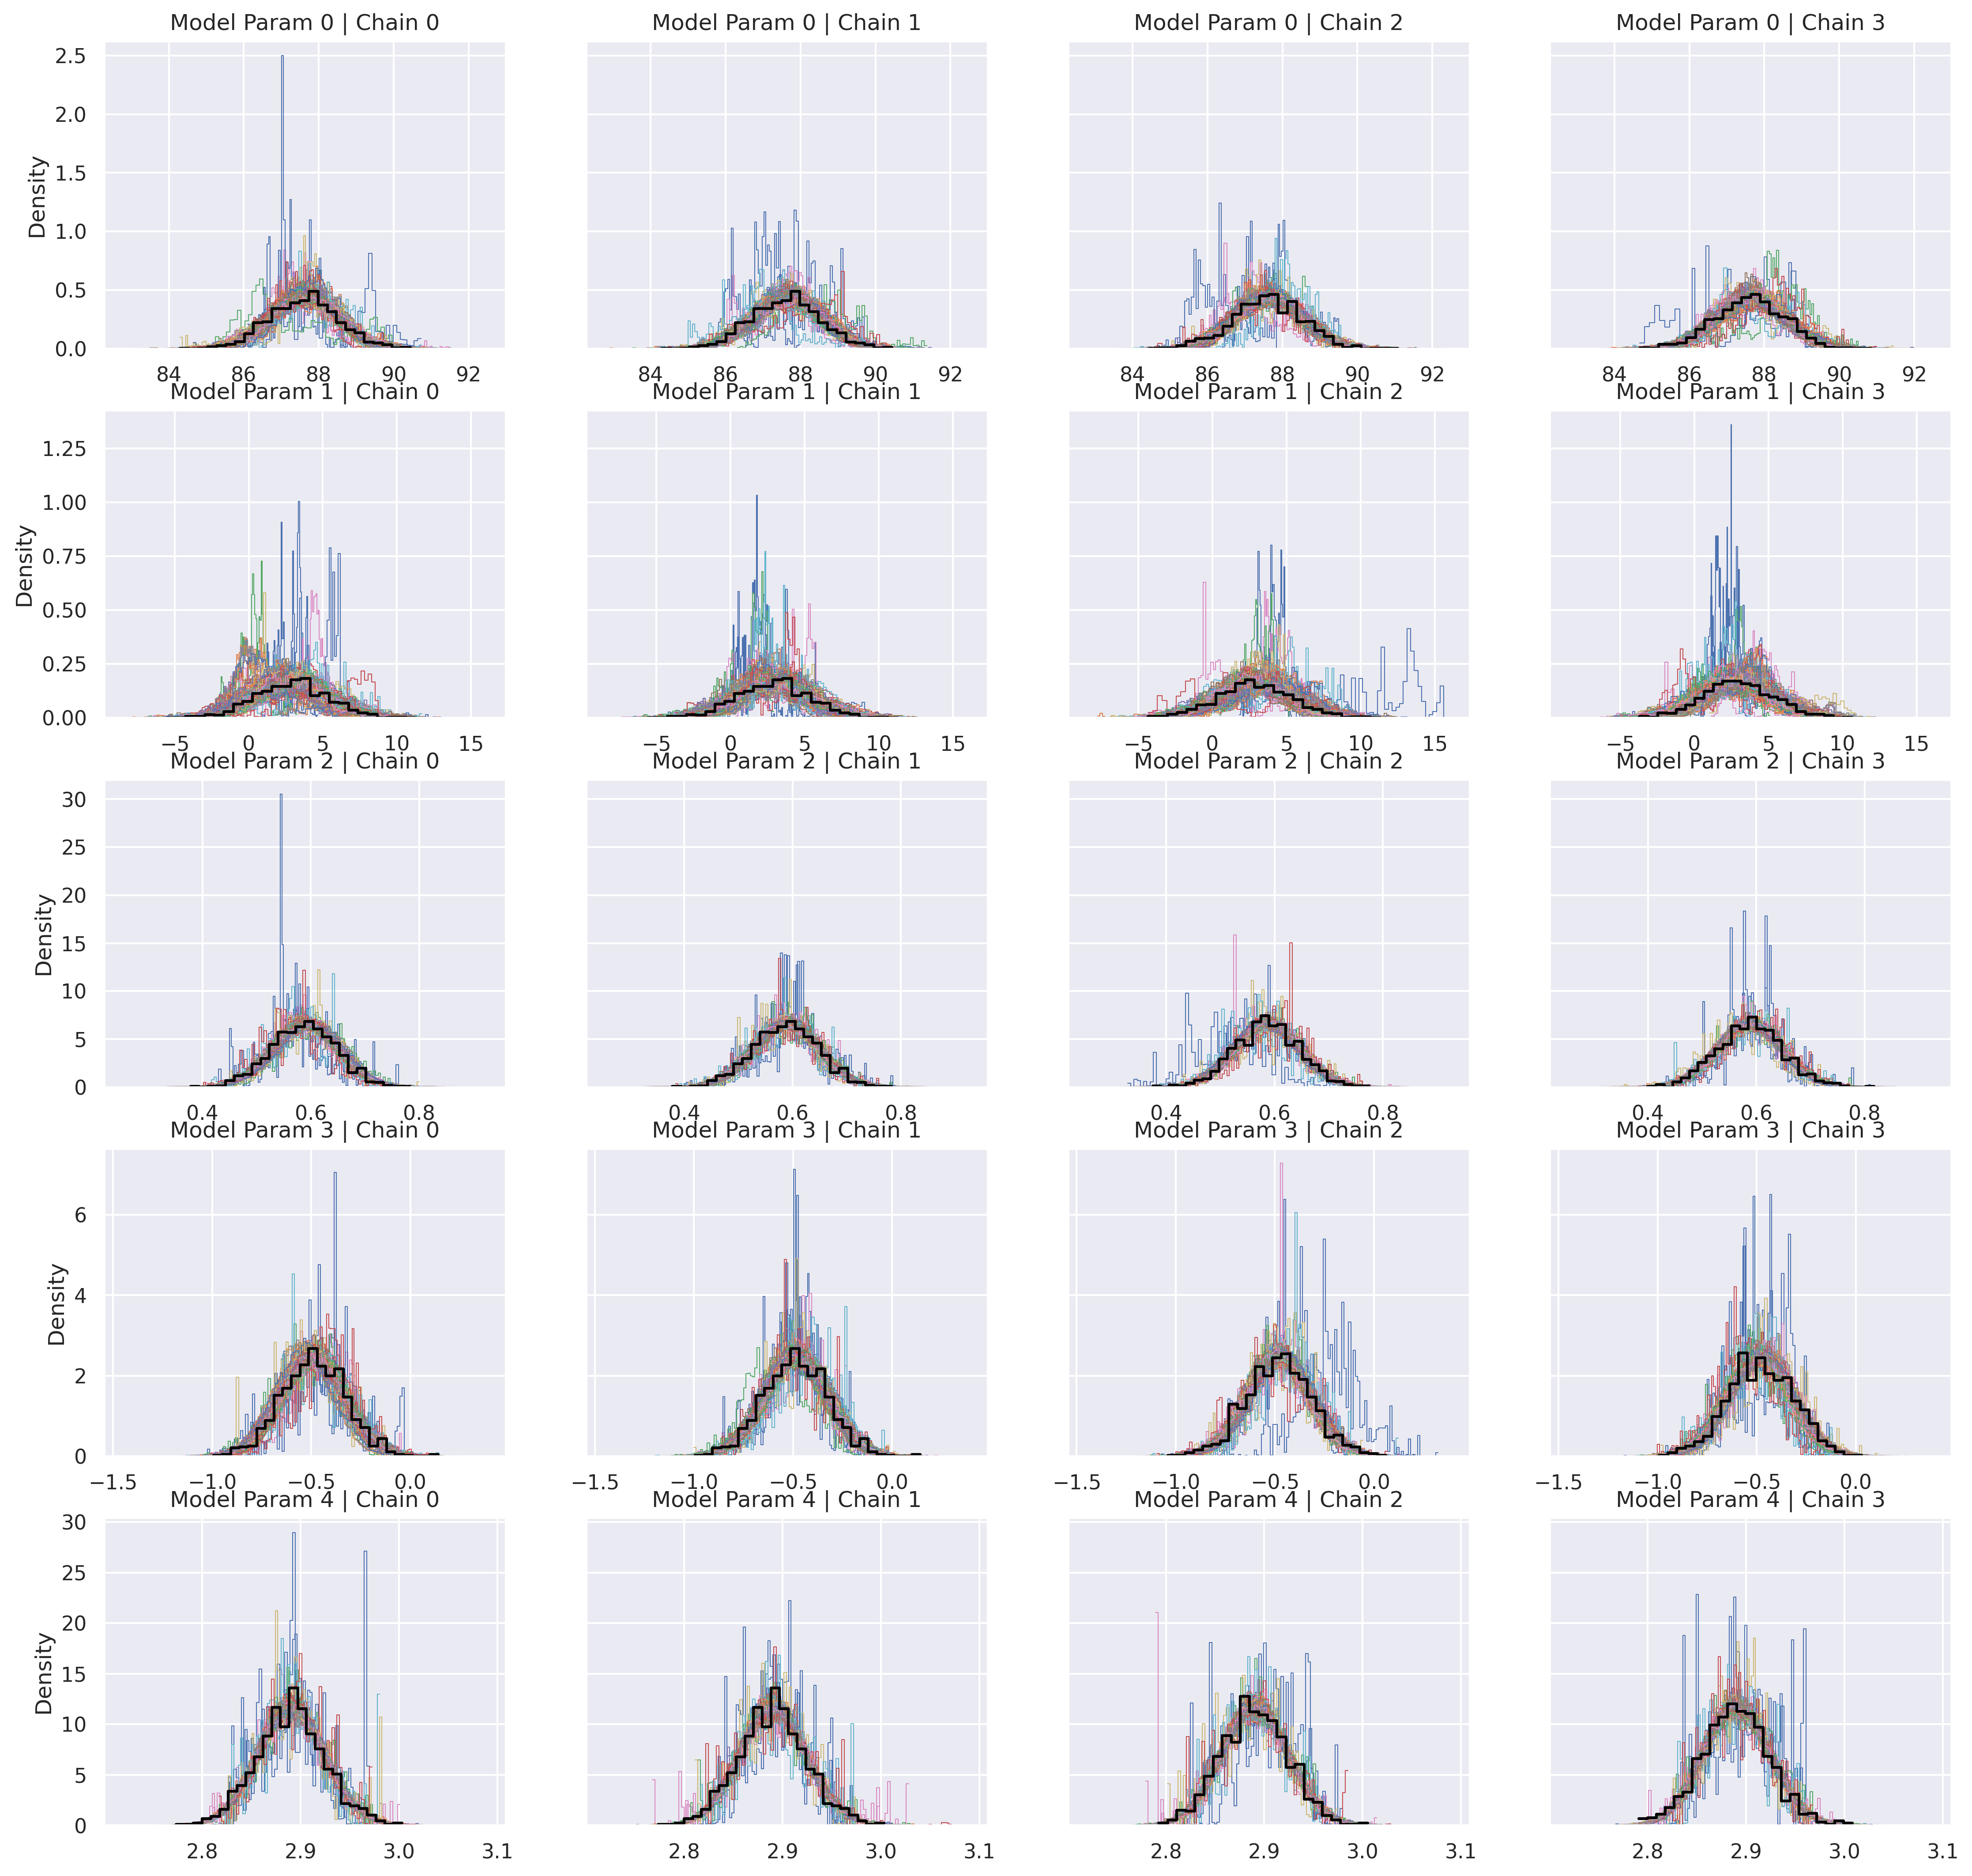

ValueError: Image size of 259200x6000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 259200x6000 with 1440 Axes>

ValueError: Image size of 216000x7500 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 216000x7500 with 50 Axes>

In [8]:
num_samplers, num_chains, num_model_params = init()
num_ref_chains = init_reference()

hist_fig, chain_fig, stats_fig, stats_df = eval(
    num_samplers, num_chains, num_model_params, min(num_ref_chains, num_chains)
)

In [ ]:
stats_df.head(10)